In [1]:
import re
import pandas as pd
import bs4
import requests
import spacy
from spacy import displacy


from spacy.matcher import Matcher 
from spacy.tokens import Span 

from spacy import displacy

import networkx as nx

import matplotlib.pyplot as plt
from tqdm import tqdm

pd.set_option('display.max_colwidth', 200)
%matplotlib inline

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [5]:
#!python -m spacy download en_core_web_lg

In [4]:
nlp = spacy.load('en_core_web_lg')

In [6]:
doc = nlp("the drawdown process is governed by astm standard d823")

for tok in doc:
  print(tok.text, "...", tok.dep_)

the ... det
drawdown ... compound
process ... nsubjpass
is ... auxpass
governed ... ROOT
by ... agent
astm ... compound
standard ... compound
d823 ... pobj


In [5]:
def get_entities(sent):
  ## chunk 1
  ent1 = ""
  ent2 = ""

  prv_tok_dep = ""    # dependency tag of previous token in the sentence
  prv_tok_text = ""   # previous token in the sentence

  prefix = ""
  modifier = ""

  #############################################################
  
  for tok in nlp(sent):
    ## chunk 2
    # if token is a punctuation mark then move on to the next token
    if tok.dep_ != "punct":
      # check: token is a compound word or not
      if tok.dep_ == "compound":
        prefix = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text
      
      # check: token is a modifier or not
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text
      
      ## chunk 3
      if tok.dep_.find("subj") == True:
        ent1 = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""      

      ## chunk 4
      if tok.dep_.find("obj") == True:
        ent2 = modifier +" "+ prefix +" "+ tok.text
        
      ## chunk 5  
      # update variables
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text
  #############################################################

  return [ent1.strip(), ent2.strip()]

In [6]:
def get_relation(sent):

  doc = nlp(sent)

  # Matcher class object 
  matcher = Matcher(nlp.vocab)

  #define the pattern 
  pattern = [{'DEP':'ROOT'}, 
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}] 

  matcher.add("matching_1",  [pattern]) 

  matches = matcher(doc)
  k = len(matches) - 1

  span = doc[matches[k][1]:matches[k][2]] 

  return(span.text)

In [7]:
get_entities("the film had 200 patents")

['film', '200  patents']

In [8]:
sent1 = "suppressor phosphatase  and  tensin homolog  (PTEN)  function  increases  B7-H1  expression  and immune resistance in glioma"

In [9]:
doc = nlp(sent1)

for tok in doc:
  print(tok.text, "...", tok.dep_)

suppressor ... compound
phosphatase ... nsubj
  ... dep
and ... cc
  ... dep
tensin ... conj
homolog ... nsubj
  ... dep
( ... punct
PTEN ... appos
) ... punct
  ... dep
function ... compound
  ... dep
increases ... ROOT
  ... dep
B7 ... compound
- ... punct
H1 ... compound
  ... dep
expression ... dobj
  ... dep
and ... cc
immune ... amod
resistance ... conj
in ... prep
glioma ... pobj


In [10]:
print(get_entities(sent1))
print(get_relation(sent1))

['homolog', 'immune B7 H1 glioma']
increases


In [11]:
sent2 = "Phase II trial Evaluating Predicting of Response to Adjuvant Treatment with Immune \nCheckpoint Inhibition (ICI) in Patients with Newly Diagnosed Glioblastoma or Gliosarcoma"

In [12]:
doc = nlp(sent2)

for tok in doc:
  print(tok.text, "...", tok.dep_)

Phase ... compound
II ... compound
trial ... ROOT
Evaluating ... acl
Predicting ... dobj
of ... prep
Response ... pobj
to ... prep
Adjuvant ... compound
Treatment ... pobj
with ... prep
Immune ... compound

 ... dep
Checkpoint ... compound
Inhibition ... pobj
( ... punct
ICI ... appos
) ... punct
in ... prep
Patients ... pobj
with ... prep
Newly ... advmod
Diagnosed ... amod
Glioblastoma ... pobj
or ... cc
Gliosarcoma ... conj


In [13]:
print(get_entities(sent2))
print(get_relation(sent2))

['', 'Diagnosed Checkpoint Glioblastoma']
trial


In [14]:
sent3 = "The immunosuppressive nature of GBM may be reversible with immune checkpoint \ninhibitor (ICI) however initial studies have yet to demonstrate this"

In [15]:
print(get_entities(sent3))
print(get_relation(sent3))

['initial checkpoint studies', 'yet  this']
be reversible


In [16]:
doc = nlp(sent3)

for tok in doc:
  print(tok.text, "...", tok.dep_)

The ... det
immunosuppressive ... amod
nature ... nsubj
of ... prep
GBM ... pobj
may ... aux
be ... ROOT
reversible ... acomp
with ... prep
immune ... amod
checkpoint ... compound

 ... dep
inhibitor ... pobj
( ... punct
ICI ... appos
) ... punct
however ... advmod
initial ... amod
studies ... nsubj
have ... advcl
yet ... advmod
to ... aux
demonstrate ... xcomp
this ... dobj


In [37]:
doc = nlp("Autonomous cars shift insurance liability toward manufacturers")
for chunk in doc.noun_chunks:
    #print(chunk.root.head.children)
    
    print(chunk.root)
    print(chunk.text, " - ", chunk.root.text, " - ", chunk.root.dep_, " - ",
            chunk.root.head.text)
    
    for i in chunk.root.children:
      print(i.text + ' - ' + i.dep_+ ' - ' + i.ent_id_)
    print('---')
    for i in chunk.root.head.children:
      print(i.text + ' - ' + i.dep_ + ' - ' + i.ent_id_)
      

    print('========')


cars
Autonomous cars  -  cars  -  nsubj  -  shift
Autonomous - amod - 
---
cars - nsubj - 
liability - dobj - 
toward - prep - 
liability
insurance liability  -  liability  -  dobj  -  shift
insurance - compound - 
---
cars - nsubj - 
liability - dobj - 
toward - prep - 
manufacturers
manufacturers  -  manufacturers  -  pobj  -  toward
---
manufacturers - pobj - 


In [ ]:
sources = []
relations = []
targets = []

In [38]:
sources = ['Autonomous cars', 'insurance liability']
targets = ['insurance liability', 'manufacturers' ]
relations = ['shift', 'towards']

In [39]:
kg_df = pd.DataFrame({'source': sources, 'target': targets, 'edge': relations})
kg_df

,source,target,edge
0,Autonomous cars,insurance liability,shift
1,insurance liability,manufacturers,towards


In [42]:
import networkx as nx
G = nx.from_pandas_edgelist(kg_df, "source", "target", edge_attr="edge")
nx_SG_d1 = nx.dfs_tree(G)
edge_labels = nx.get_edge_attributes(G,'edge')

edge_labels

{('Autonomous cars', 'insurance liability'): 'shift',
 ('insurance liability', 'manufacturers'): 'towards'}

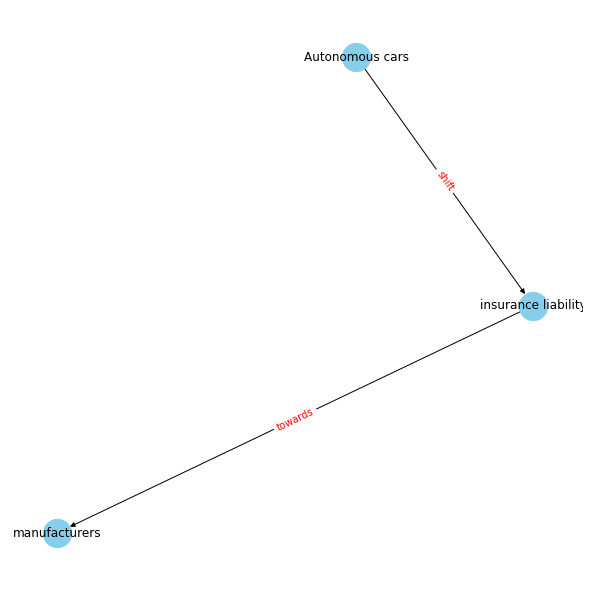

In [44]:
def plot_graph(graph): 
    plt.figure(figsize=(8,8))
    pos = nx.spring_layout(graph, k=0.5)  # k regulates the distance between nodes
    nx.draw(graph, with_labels=True, node_color='skyblue', node_size=800, edge_cmap=plt.cm.Blues, pos=pos)
    nx.draw_networkx_edge_labels( G, pos,edge_labels=edge_labels,font_color='red')
    plt.show()

plot_graph(nx_SG_d1)

In [14]:
displacy.render(doc, style="dep")

'<svg xmlns="http://www.w3.org/2000/svg" xmlns:xlink="http://www.w3.org/1999/xlink" xml:lang="en" id="6846ced5997e41dda82505517b1d3779-0" class="displacy" width="1275" height="399.5" direction="ltr" style="max-width: none; height: 399.5px; color: #000000; background: #ffffff; font-family: Arial; direction: ltr">\n<text class="displacy-token" fill="currentColor" text-anchor="middle" y="309.5">\n    <tspan class="displacy-word" fill="currentColor" x="50">Autonomous</tspan>\n    <tspan class="displacy-tag" dy="2em" fill="currentColor" x="50">ADJ</tspan>\n</text>\n\n<text class="displacy-token" fill="currentColor" text-anchor="middle" y="309.5">\n    <tspan class="displacy-word" fill="currentColor" x="225">cars</tspan>\n    <tspan class="displacy-tag" dy="2em" fill="currentColor" x="225">NOUN</tspan>\n</text>\n\n<text class="displacy-token" fill="currentColor" text-anchor="middle" y="309.5">\n    <tspan class="displacy-word" fill="currentColor" x="400">shift</tspan>\n    <tspan class="disp

In [22]:
print('=========================================')
print(sent3)
print('=========================================')
doc = nlp(sent3)
for chunk in doc.noun_chunks:
    print(chunk.text, " - ", chunk.root.text, " - ", chunk.root.dep_, " - ",
            chunk.root.head.text)
print('=========================================')
displacy.render(doc, style="dep")
print('=========================================')
for tok in doc:
  print(tok.text, "...", tok.dep_)

The immunosuppressive nature of GBM may be reversible with immune checkpoint 
inhibitor (ICI) however initial studies have yet to demonstrate this
The immunosuppressive nature  -  nature  -  nsubj  -  be
GBM  -  GBM  -  pobj  -  of
immune checkpoint 
inhibitor  -  inhibitor  -  pobj  -  with
ICI  -  ICI  -  appos  -  inhibitor
initial studies  -  studies  -  nsubj  -  have
this  -  this  -  dobj  -  demonstrate
The ... det
immunosuppressive ... amod
nature ... nsubj
of ... prep
GBM ... pobj
may ... aux
be ... ROOT
reversible ... acomp
with ... prep
immune ... amod
checkpoint ... compound

 ... dep
inhibitor ... pobj
( ... punct
ICI ... appos
) ... punct
however ... advmod
initial ... amod
studies ... nsubj
have ... advcl
yet ... advmod
to ... aux
demonstrate ... xcomp
this ... dobj


In [23]:
displacy.render(doc, style="dep")

'<svg xmlns="http://www.w3.org/2000/svg" xmlns:xlink="http://www.w3.org/1999/xlink" xml:lang="en" id="0137015f4d2a44df8b4e81c005af5374-0" class="displacy" width="3900" height="574.5" direction="ltr" style="max-width: none; height: 574.5px; color: #000000; background: #ffffff; font-family: Arial; direction: ltr">\n<text class="displacy-token" fill="currentColor" text-anchor="middle" y="484.5">\n    <tspan class="displacy-word" fill="currentColor" x="50">The</tspan>\n    <tspan class="displacy-tag" dy="2em" fill="currentColor" x="50">DET</tspan>\n</text>\n\n<text class="displacy-token" fill="currentColor" text-anchor="middle" y="484.5">\n    <tspan class="displacy-word" fill="currentColor" x="225">immunosuppressive</tspan>\n    <tspan class="displacy-tag" dy="2em" fill="currentColor" x="225">ADJ</tspan>\n</text>\n\n<text class="displacy-token" fill="currentColor" text-anchor="middle" y="484.5">\n    <tspan class="displacy-word" fill="currentColor" x="400">nature</tspan>\n    <tspan class

In [33]:
html = displacy.render(doc, style="ent", page=True)
html

'<!DOCTYPE html>\n<html lang="en">\n    <head>\n        <title>displaCy</title>\n    </head>\n\n    <body style="font-size: 16px; font-family: -apple-system, BlinkMacSystemFont, \'Segoe UI\', Helvetica, Arial, sans-serif, \'Apple Color Emoji\', \'Segoe UI Emoji\', \'Segoe UI Symbol\'; padding: 4rem 2rem; direction: ltr">\n<figure style="margin-bottom: 6rem">\n<div class="entities" style="line-height: 2.5; direction: ltr">The immunosuppressive nature of \n<mark class="entity" style="background: #7aecec; padding: 0.45em 0.6em; margin: 0 0.25em; line-height: 1; border-radius: 0.35em;">\n    GBM\n    <span style="font-size: 0.8em; font-weight: bold; line-height: 1; border-radius: 0.35em; vertical-align: middle; margin-left: 0.5rem">ORG</span>\n</mark>\n may be reversible with immune checkpoint </br>inhibitor (ICI) however initial studies have yet to demonstrate this</div>\n</figure>\n</body>\n</html>'

In [29]:
from pathlib import Path

In [32]:
svg = displacy.render(doc, style="ent")
output_path = Path("/sentence.svg")
output_path.open("w", encoding="utf-8").write(svg)

513

In [45]:
print(sent2)
doc = nlp(sent2)
for chunk in doc.noun_chunks:
    print(chunk.text, " - ", chunk.root.text, " - ", chunk.root.dep_, " - ",
            chunk.root.head.text)

print('=========================================')
for tok in doc:
  print(tok.text, "...", tok.dep_)

Phase II trial Evaluating Predicting of Response to Adjuvant Treatment with Immune 
Checkpoint Inhibition (ICI) in Patients with Newly Diagnosed Glioblastoma or Gliosarcoma
Phase II trial  -  trial  -  ROOT  -  trial
Predicting  -  Predicting  -  dobj  -  Evaluating
Response  -  Response  -  pobj  -  of
Adjuvant Treatment  -  Treatment  -  pobj  -  to
Immune 
Checkpoint Inhibition  -  Inhibition  -  pobj  -  with
ICI  -  ICI  -  appos  -  Inhibition
Patients  -  Patients  -  pobj  -  in
Newly Diagnosed Glioblastoma  -  Glioblastoma  -  pobj  -  with
Gliosarcoma  -  Gliosarcoma  -  conj  -  Glioblastoma
Phase ... compound
II ... compound
trial ... ROOT
Evaluating ... acl
Predicting ... dobj
of ... prep
Response ... pobj
to ... prep
Adjuvant ... compound
Treatment ... pobj
with ... prep
Immune ... compound

 ... dep
Checkpoint ... compound
Inhibition ... pobj
( ... punct
ICI ... appos
) ... punct
in ... prep
Patients ... pobj
with ... prep
Newly ... advmod
Diagnosed ... amod
Glioblastoma

In [44]:
print(sent1)
doc = nlp(sent1)
for chunk in doc.noun_chunks:
    print(chunk.text, " - ", chunk.root.text, " - ", chunk.root.dep_, " - ",
            chunk.root.head.text)

print('=========================================')
for tok in doc:
  print(tok.text, "...", tok.dep_)

suppressor phosphatase  and  tensin homolog  (PTEN)  function  increases  B7-H1  expression  and immune resistance in glioma
suppressor phosphatase  -  phosphatase  -  nsubj  -  increases
tensin  -  tensin  -  conj  -  phosphatase
homolog  -  homolog  -  nsubj  -  function
(PTEN  -  PTEN  -  appos  -  homolog
B7-H1  expression  -  expression  -  dobj  -  increases
immune resistance  -  resistance  -  conj  -  expression
glioma  -  glioma  -  pobj  -  in
suppressor ... compound
phosphatase ... nsubj
  ... dep
and ... cc
  ... dep
tensin ... conj
homolog ... nsubj
  ... dep
( ... punct
PTEN ... appos
) ... punct
  ... dep
function ... compound
  ... dep
increases ... ROOT
  ... dep
B7 ... compound
- ... punct
H1 ... compound
  ... dep
expression ... dobj
  ... dep
and ... cc
immune ... amod
resistance ... conj
in ... prep
glioma ... pobj
